# Data Mining Coursework 2
This Jupyter Notebook contains code that performs the following operations:
1. Data Exploration, Visualisation, and Summary
2. Data Cleansing and Pre-processing
3. Supervised Model Training, Tuning, and Evaluation
4. Unsupervised Learning using Clustering Algorithms

## Prior setups
Importing the necessary libraries and relevant folder and files.

In [36]:
import math as m
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline
from numpy import nan
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
# The types of classifiers to use
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Sampling techniques to use
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
# from imblearn.under_sampling import NearMiss

print("Setup complete.")

data_folder = "data/"
train_data_file = "disease_train.csv"
test_data_file = "disease_test.csv"
prediction_data_file = "predictedTarget.csv"

Setup complete.


Read the CSV files and store the data into a Pandas DataFrame.

In [2]:
train_data = pd.read_csv(data_folder + train_data_file, delimiter=",")
test_data = pd.read_csv(data_folder + test_data_file, delimiter=",")
print(train_data.head(10))
print(test_data.head(10))

       id  age  gender sick pregnant  test_X1  test_X2  test_X3  test_X4  \
0  PA1001   59    male   no       no      7.8      NaN     89.0     0.85   
1  PA1002   48  female   no       no      1.5      2.5    101.0     0.97   
2  PA1003   77    male   no       no      7.3      1.2     57.0     1.28   
3  PA1004   42  female   no       no      1.2      2.5    106.0     0.98   
4  PA1005   38  female   no       no      0.6      1.9     95.0      NaN   
5  PA1006   44    male   no       no      3.0      2.0    115.0     1.10   
6  PA1007   90  female   no       no      1.5      1.8     98.0     0.94   
7  PA1008   69  female   no       no      6.9      NaN    109.0     1.03   
8  PA1009   33  female   no       no      0.1      1.7    104.0     0.80   
9  PA1010   42  female   no       no      1.9      2.2    126.0     0.97   

   test_X5  ...  tumor disorder medication_A medication_B mental_health  \
0    105.0  ...     no       no           no           no            no   
1    104.0  .

## 1. Data Exploration, Visualisation, and Summary
As the data mining procedure mainly involves the training data, most of the operations will be solely done on the training data and the test data will follow suit.

### Get column names
In the cell below, the names of the categorical and numerical columns are obtained and stored in a list. This method avoids writing them down manually. 

`train_data` has a `target` column unlike `test_data` which will not be included in the categorical columns list.

In [3]:
print(f"train_categorical_features = {list(train_data.select_dtypes(include=['object']).columns)}")
print(f"train_numerical_features = {list(train_data.select_dtypes(include=['int64', 'float64']).columns)}")
print("")
print(f"test_categorical_features = {list(test_data.select_dtypes(include=['object']).columns)}")
print(f"test_numerical_features = {list(test_data.select_dtypes(include=['int64', 'float64']).columns)}")
print("")
categorical_features = list(train_data.select_dtypes(include=["object"]).columns)
categorical_features.remove("target")
print(f"categorical_features = {categorical_features}")
numerical_features = list(train_data.select_dtypes(include=["int64", "float64"]).columns)
print(f"numerical_features = {numerical_features}")
all_features = list(train_data.columns)
all_features.remove("target")
print(f"All columns = {all_features}")

train_categorical_features = ['id', 'gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'disorder', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1', 'suspect', 'target']
train_numerical_features = ['age', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5', 'test_X6']

test_categorical_features = ['id', 'gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'disorder', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1', 'suspect']
test_numerical_features = ['age', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5', 'test_X6']

categorical_features = ['id', 'gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'disorder', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1', 'suspect']
numerical_features = ['age', 'test_X1', 'test_X2', 'test_X3

### Data Summary
Get a statistical summary of the numerical features.

In [4]:
print(f"Train data summary statistics: \n{train_data.describe()}")
print("\n")
print(f"Test data summary statistics: \n{test_data.describe()}")

Train data summary statistics: 
                age      test_X1      test_X2      test_X3      test_X4  \
count   4250.000000  3839.000000  3007.000000  4034.000000  3858.000000   
mean      67.374824     7.342463     2.035580   104.919623     0.970846   
std     1004.518821    32.657963     0.920404    35.496255     0.162474   
min        1.000000     0.005000     0.050000     2.000000     0.250000   
25%       37.000000     0.600000     1.600000    87.000000     0.870000   
50%       55.000000     1.500000     1.900000   102.000000     0.960000   
75%       67.000000     3.000000     2.300000   121.000000     1.060000   
max    65526.000000   530.000000    18.000000   430.000000     1.960000   

           test_X5     test_X6  
count  3863.000000  154.000000  
mean    110.090834   23.325974  
std      39.837621    5.317032  
min       1.400000    8.400000  
25%      92.000000   20.000000  
50%     107.000000   24.000000  
75%     125.000000   27.000000  
max     642.000000   45.0000

### Check Column Data Types and Missing Values
Check the data type of the columns and check how many entries are non-null in the training and test data. 60% of the total entries for each feature have to be non-null in order for a feature to be valid for the train data. 60% of 4250 `train_data` entries is 2550. Looking at the columns, column `test_X6` has less than 2550 entries that are non-null values. Hence, column `text_X6` can be removed from both datasets. 

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4250 non-null   object 
 1   age              4250 non-null   int64  
 2   gender           4109 non-null   object 
 3   sick             4250 non-null   object 
 4   pregnant         4250 non-null   object 
 5   test_X1          3839 non-null   float64
 6   test_X2          3007 non-null   float64
 7   test_X3          4034 non-null   float64
 8   test_X4          3858 non-null   float64
 9   test_X5          3863 non-null   float64
 10  test_X6          154 non-null    float64
 11  concern_type1    4250 non-null   object 
 12  concern_type2    4250 non-null   object 
 13  enlargement      4250 non-null   object 
 14  tumor            4250 non-null   object 
 15  disorder         4250 non-null   object 
 16  medication_A     4250 non-null   object 
 17  medication_B  

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               750 non-null    object 
 1   age              750 non-null    int64  
 2   gender           724 non-null    object 
 3   sick             750 non-null    object 
 4   pregnant         750 non-null    object 
 5   test_X1          674 non-null    float64
 6   test_X2          542 non-null    float64
 7   test_X3          717 non-null    float64
 8   test_X4          678 non-null    float64
 9   test_X5          679 non-null    float64
 10  test_X6          25 non-null     float64
 11  concern_type1    750 non-null    object 
 12  concern_type2    750 non-null    object 
 13  enlargement      750 non-null    object 
 14  tumor            750 non-null    object 
 15  disorder         750 non-null    object 
 16  medication_A     750 non-null    object 
 17  medication_B    

Count the number of missing data points for each feature. Because `gender` is a categorical feature, there is no choice but to remove rows where their `gender` feature is missing a value. `test_X1` to `test_X5` are all numerical columns, allowing the missing values to be imputed in some way.

In [7]:
print("Train Data: ")
print(train_data.isnull().sum())
print("\n")
print("Test Data: ")
print(test_data.isnull().sum())

Train Data: 
id                    0
age                   0
gender              141
sick                  0
pregnant              0
test_X1             411
test_X2            1243
test_X3             216
test_X4             392
test_X5             387
test_X6            4096
concern_type1         0
concern_type2         0
enlargement           0
tumor                 0
disorder              0
medication_A          0
medication_B          0
mental_health         0
mood_stabiliser       0
surgery               0
treatment_type1       0
suspect               0
target                0
dtype: int64


Test Data: 
id                   0
age                  0
gender              26
sick                 0
pregnant             0
test_X1             76
test_X2            208
test_X3             33
test_X4             72
test_X5             71
test_X6            725
concern_type1        0
concern_type2        0
enlargement          0
tumor                0
disorder             0
medication_A    

### Number of unique values
The cell below counts the total occurrances for each value in every column. The column `id` has only unique values and column `disorder` is constant for all entries, meaning that both can be safely removed from the dataset. 

Some columns contains outliers which will need to be preproccessed later like `age` which not only has outrageous outliers. Some columns have highly imbalanced data which will also need to be accounted for.

In [8]:
for column in train_data.columns:
    print(train_data[column].value_counts(), "\n")

PA1001    1
PA3839    1
PA3825    1
PA3826    1
PA3827    1
         ..
PA2423    1
PA2424    1
PA2425    1
PA2426    1
PA5250    1
Name: id, Length: 4250, dtype: int64 

59       100
62        97
60        94
58        93
55        89
        ... 
65526      1
4          1
97         1
455        1
94         1
Name: age, Length: 94, dtype: int64 

female    2787
male      1322
Name: gender, dtype: int64 

no     4095
yes     155
Name: sick, dtype: int64 

no     4235
yes      15
Name: pregnant, dtype: int64 

0.100      117
1.300      109
1.500      106
1.100      104
1.200      104
          ... 
164.000      1
0.255        1
170.000      1
56.000       1
165.000      1
Name: test_X1, Length: 334, dtype: int64 

1.8    237
2.0    231
1.9    223
1.7    209
2.1    191
      ... 
5.6      1
6.4      1
5.4      1
4.8      1
6.9      1
Name: test_X2, Length: 77, dtype: int64 

101.0    91
98.0     81
95.0     78
93.0     78
90.0     71
         ..
359.0     1
18.0      1
27.0      1
218.

### Data Distribution Visualisation
The cell below shows the distribution of the train dataset which clearly shows that it is imbalanced. Some prepocessing will need to be done in order to make the data more balanced later.

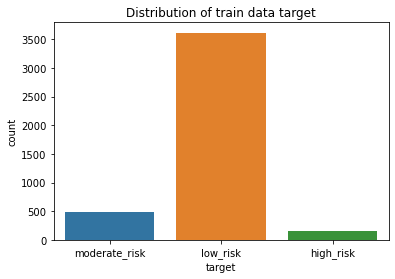

In [10]:
sns.countplot(x='target', data=train_data)
plt.title("Distribution of train data target")
#Save the plot to the working directory
plt.savefig(data_folder + 'target_distribution.jpg')

### Categorical Column Distribution Visualisation
The cell below creates plots showing distribution for almost every column against `target` except `id`, `disorder`, and `target` as they only have unique values, constant values, and same values respectively.

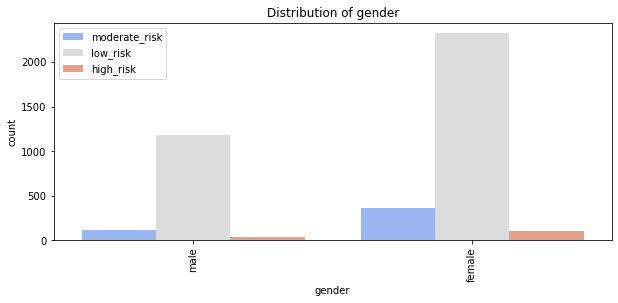

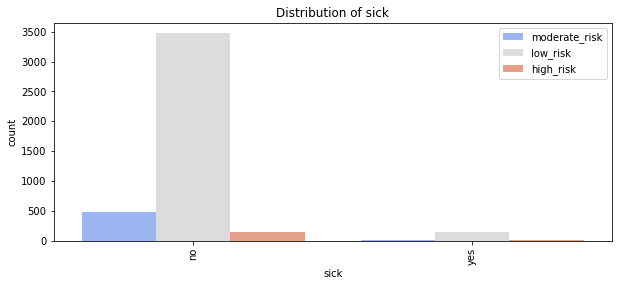

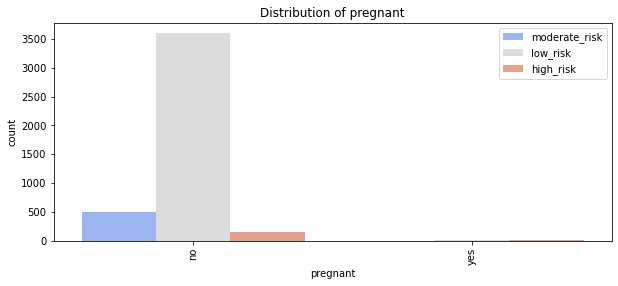

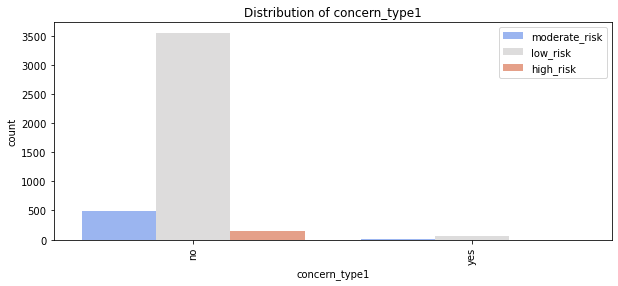

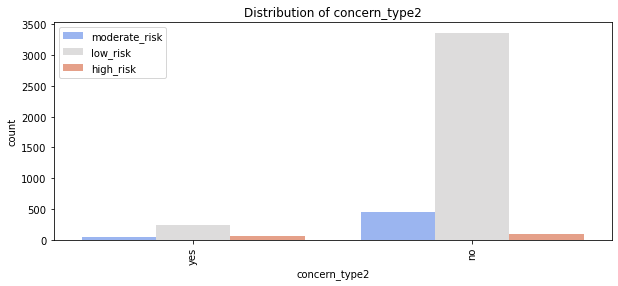

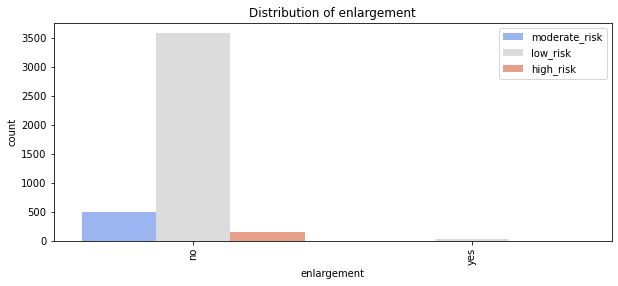

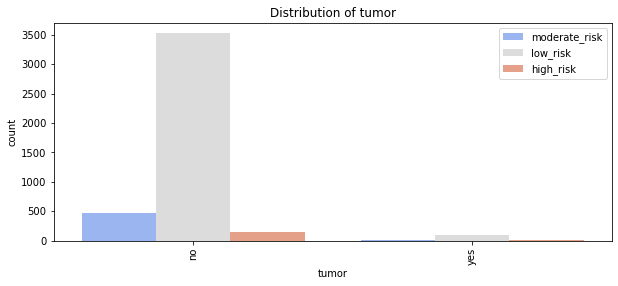

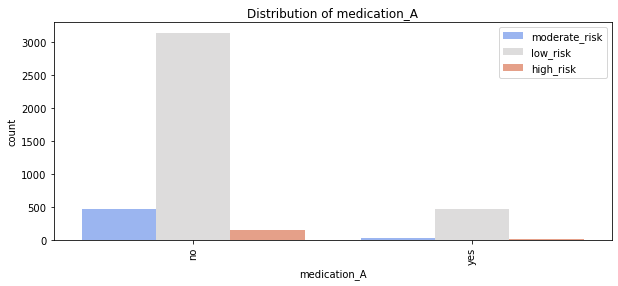

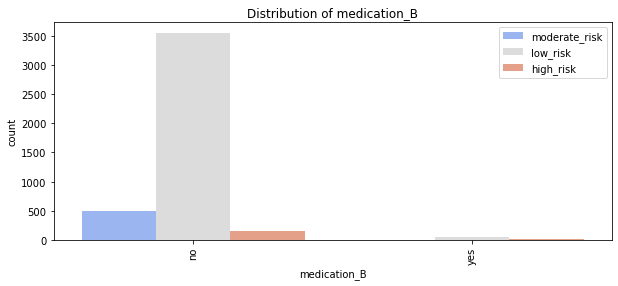

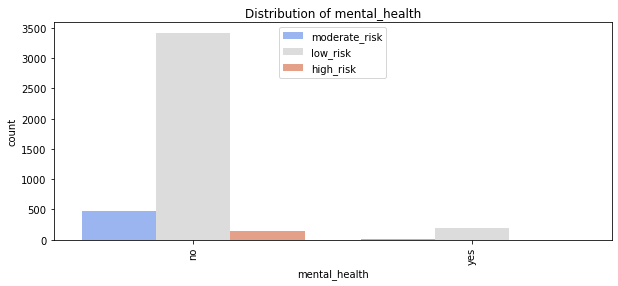

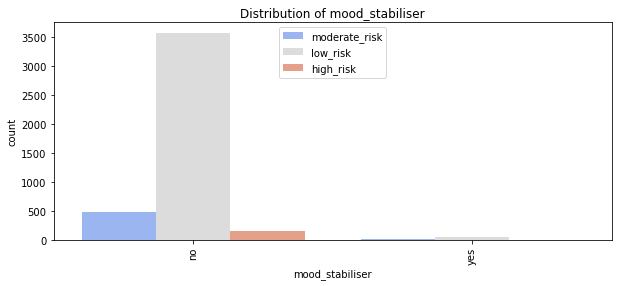

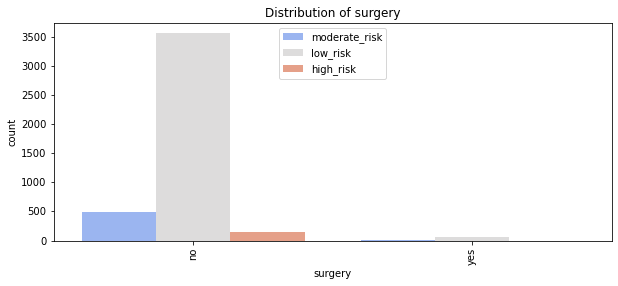

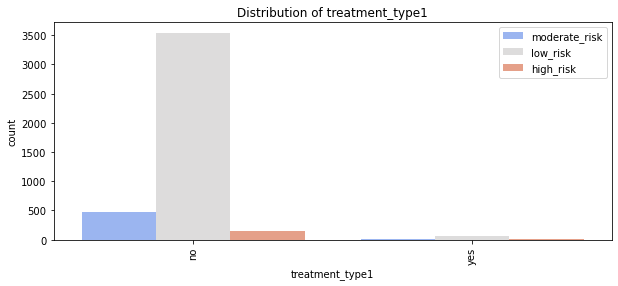

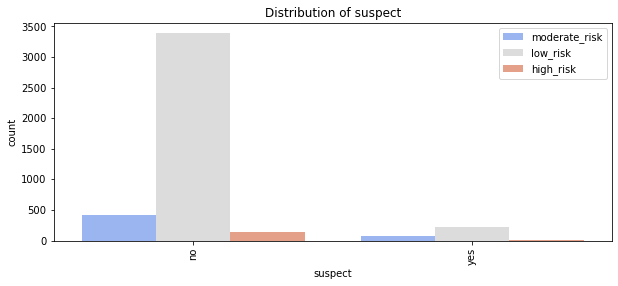

In [11]:
for column in categorical_features:
    if column in ["id", "disorder", "target"]:
        continue
    #make sure that plot only takes the two plots below by using the following command
    plt.figure(figsize=(10,4))
    plt.xticks(rotation=90) 
    sns.countplot(x=column, hue='target', palette="coolwarm", data=train_data)
    #include a legend
    plt.legend()
    #include a dynamic title
    plt.title("Distribution of " +column)
    #Save the plot to the working directory
    plt.savefig(data_folder+column+'.jpg')

### Numerical Column Distribution Visualisation
Boxplots can be plotted using a categorical column against all numerical columns by changing the value of the `cat` variable. The categorical columns that can be used are `gender`, `sick`, `pregnant`, `concern_type1`, `concern_type2`, `enlargement`, `tumor`, `medication_A`, `medication_B`, `mental_health`, `mood_stabiliser`, `surgery`, `treatment_type1`, `suspect`.

The `gender` feature is used here as the plots above show `gender` having a more visible variation and there are clearly a fair amount of outliers for all the numerical features which will need to be handled during preprocessing. Especially `age` where one outlier causes the boxplot to be unreadable.

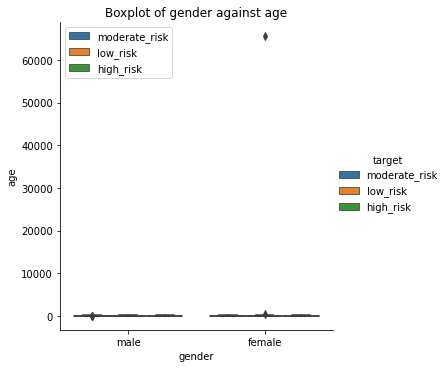

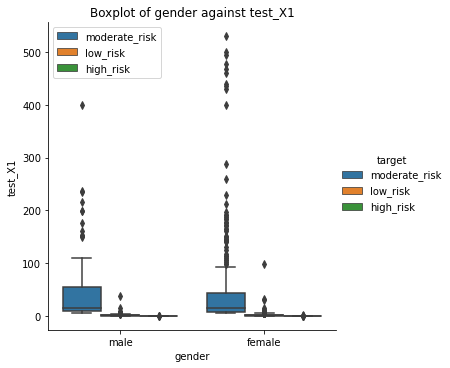

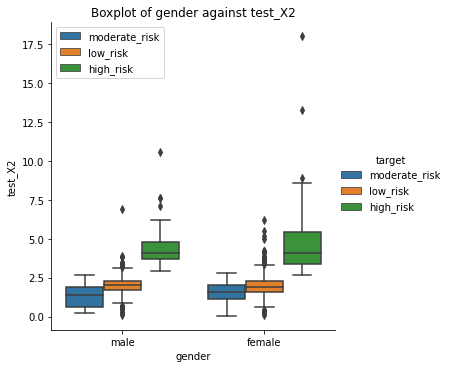

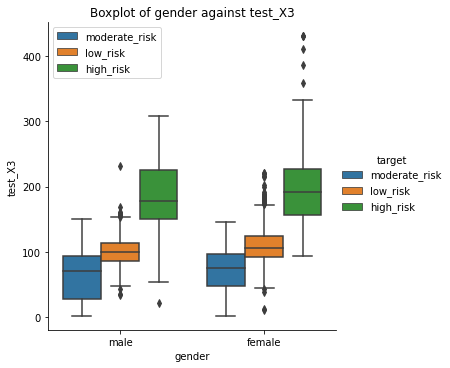

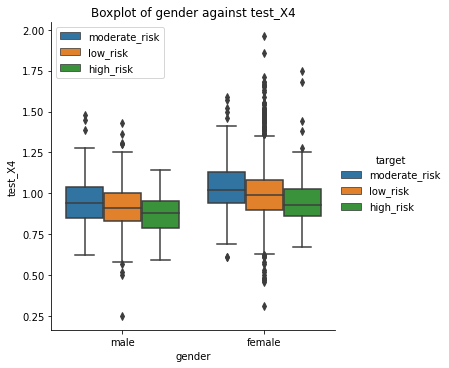

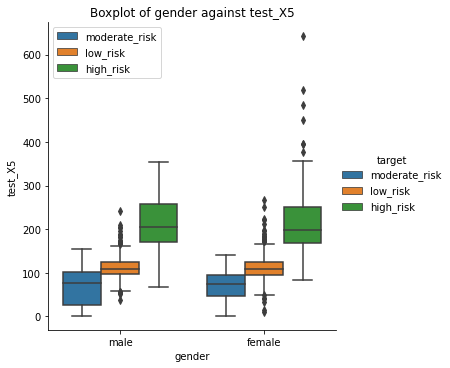

In [12]:
cat = "gender"
for num in numerical_features:
    if num == "test_X6" or cat in ["id", "disorder", "target"]:
        continue
    sns.catplot(x=cat, y=num, hue="target",  kind="box", data=train_data)
    #include a legend
    plt.legend()
    #include a dynamic title
    plt.title("Boxplot of " + cat + " against " + num)
    #Save the plot to the working directory
    plt.savefig(data_folder + cat + "_vs_"+ num +'.jpg')

Check for the outrageous `age` outliers in the train and test data. Let's assume 100 is the maximum age.

In [13]:
print(train_data[["id", "age"]][train_data["age"] > 100])
print(test_data[["id", "age"]][train_data["age"] > 100])

          id    age
2459  PA3460  65526
3477  PA4478    455
Empty DataFrame
Columns: [id, age]
Index: []


C:\Users\User\AppData\Local\Temp\ipykernel_7444\2101148061.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(test_data[["id", "age"]][train_data["age"] > 100])


### Correlation Visualisation Heatmap
The cell below visualises a correlation matrix heatmap of the numerical values and the `target` column that has been encoded. Based on the heatmap, there does not seem seem to be any correlation between medical diagnosis (`target`) and `age` or `test_X6`. However, due to the 2 huge outliers in the `age` feature, it is possible that the observations are affecting the correlation.

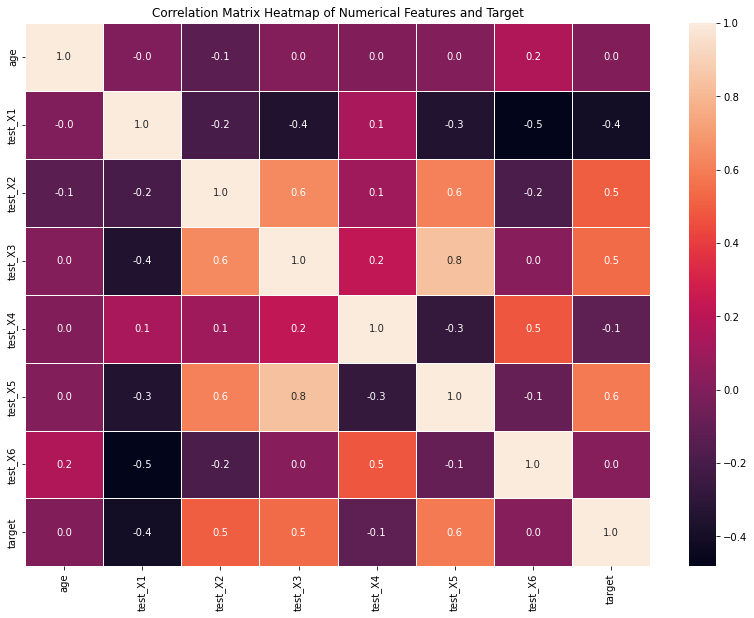

In [14]:
data = train_data[numerical_features + ["target"]]
encoder = ce.OrdinalEncoder(cols="target", handle_missing='return_nan', return_df=True)
data = encoder.fit_transform(data)
# Create a heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
a = sns.heatmap(correlation_matrix, annot=True, fmt=".1f", linewidths=.7)

# Set feature names for both axes
a.set_xticklabels(correlation_matrix.columns, rotation=90)
a.set_yticklabels(correlation_matrix.columns)

plt.title('Correlation Matrix Heatmap of Numerical Features and Target')
plt.savefig(data_folder + "num_and_target_corr_mat_heatmap.jpg")
plt.show()

After removing the observations with the extreme outliers in `age` and creating the heat map again, the correlation only has a small change. This means that age will not be a useful feature for the model.

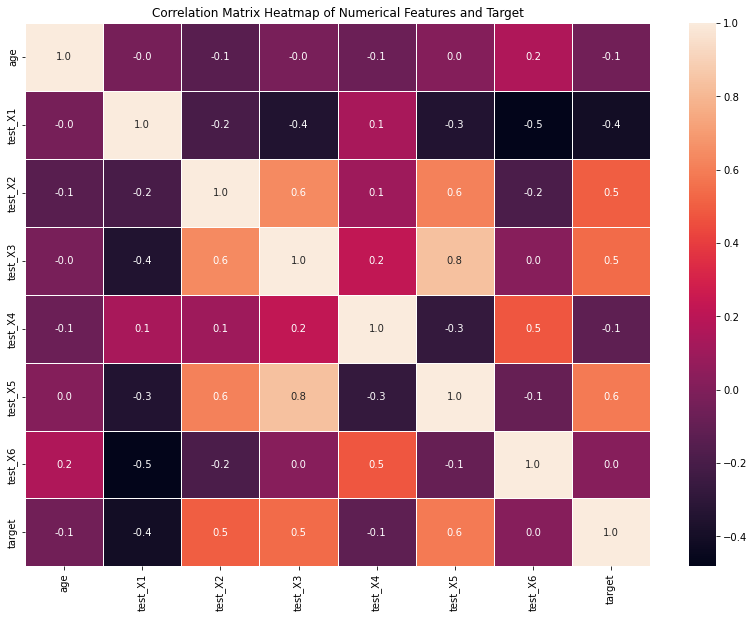

In [15]:
temp = train_data[train_data["age"] <= 100]
data = temp[numerical_features + ["target"]]
encoder = ce.OrdinalEncoder(cols="target", handle_missing='return_nan', return_df=True)
data = encoder.fit_transform(data)
# Create a heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
a = sns.heatmap(correlation_matrix, annot=True, fmt=".1f", linewidths=.7)

# Set feature names for both axes
a.set_xticklabels(correlation_matrix.columns, rotation=90)
a.set_yticklabels(correlation_matrix.columns)

plt.title('Correlation Matrix Heatmap of Numerical Features and Target')
plt.savefig(data_folder + "num_and_target_corr_mat_heatmap_no_age_outlier.jpg")
plt.show()

## 2. Data Cleansing and Pre-processing

### Remove the unnecessary columns
The first thing to do is removing the features that are considered to not have an effect on the prediction. The features to drop are:
1. `id` : All values are unique
2. `age`: Little to no correlation to target
3. `text_X6` : Too many missing values
4. `disorder` : All values are constant 
5. `suspect` : Speculation by patients and does not relate to physical or mental state, it is safe to assume that it is a feature not worth exploring. 

In [16]:
# Remove columns from train and test data
train_data.drop(columns=["id", "age", "test_X6", "disorder", "suspect"], inplace=True)
test_data.drop(columns=["id", "age", "test_X6", "disorder", "suspect"], inplace=True)
# Remove the column names from the list as well
categorical_features = [item for item in categorical_features if item not in ["id", "age", "disorder", "suspect"]]
numerical_features = [item for item in numerical_features if item != "test_X6"]
all_features = [item for item in all_features if item not in ["id", "age", "disorder", "suspect", "test_X6"]]

In [17]:
print(f"categorical_features = {categorical_features}")
print(f"numerical_features = {numerical_features}")
print(f"All columns = {all_features}")
# Check if columns have been removed from dataframe
print("train_data: ")
print(train_data)
print("test_data: ")
print(test_data)

categorical_features = ['gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1']
numerical_features = ['age', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5']
All columns = ['gender', 'sick', 'pregnant', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1']
train_data: 
      gender sick pregnant  test_X1  test_X2  test_X3  test_X4  test_X5  \
0       male   no       no      7.8      NaN     89.0     0.85    105.0   
1     female   no       no      1.5      2.5    101.0     0.97    104.0   
2       male   no       no      7.3      1.2     57.0     1.28     44.0   
3     female   no       no      1.2      2.5    106.0     0.98    108.0   
4     female   no       no      0.6      1.9     95.0      NaN

The `DataFrameImputer` class is used to impute both the categorical and numerical columns. Since there are both categorical and numerical features containing missing values, both types of features will need to be handled separately. 

### Categorical imputing 
There is a choice between imputing and removing the missing values. We will test both strategies for the missing values in categorical features. `cat_impute_type` variable determines how the missing values are handled.

0 = Simply removing entries with missing values.

1 = Replace missing values with most frequent value of the column.

2 = Replace missing values with least frequent value of the column.

### Numerical Imputing
`test_X1` to `test_X5` all have missing values. They will be imputed using mean or median of the other values.
`num_impute_type` variable determines how the missing values are handled.

0 = Missing values are imputed using mean of each column.

1 = Missing values are imputed using median of each column.

In [18]:
class DataFrameImputer(TransformerMixin):

    def __init__(self, cat_impute_type=0, num_impute_type=0):
        """Impute missing values.

        Columns of dtype object are either removed, imputed with most frequent value, or 
        imputed with least frequent value. [0, 1, 2]

        Columns of other types are imputed with mean of column, or median of column. [0, 1]

        """
        self.fill = None
        self.cat_impute = cat_impute_type
        self.num_impute = num_impute_type
            
        
    def fit(self, X):
        # Find most common value with value_counts() which returns 
        # counts in descending order so that the first element is the most frequently-occurring element.
        new_X = X
        cols = []
        impute_vals = []
        if self.cat_impute == 0:
            new_X.dropna(subset=[col for col in X if new_X[col].dtype == np.dtype('O')], inplace=True)
        else:
            for col in new_X:
                if new_X[col].dtype == np.dtype('O'):
                    cols.append(col)
                    if self.cat_impute == 1:
                        impute_vals.append(new_X[col].value_counts().index[0])
                    elif self.cat_impute == 2:
                        impute_vals.append(new_x[col].value_counts(ascending=True).index[0])
                    else:
                        print("Categoric imputation value not valid.")
            self.fill = pd.Series(impute_vals, index=cols)
        
        cols = []
        impute_vals = []
        
        for col in new_X:
            if new_X[col].dtype != np.dtype('O'):
                cols.append(col)
                if self.num_impute: 
                    impute_vals.append(new_X[col].median())
                else: 
                    impute_vals.append(new_X[col].mean())
        if self.cat_impute:
            self.fill = self.fill.append(pd.Series(impute_vals, index=cols))
        else:
            self.fill = pd.Series(impute_vals, index=cols)
            
        return self
    

    def transform(self, X):
        new_X = X
        if not self.cat_impute:
            new_X.dropna(subset=[col for col in X if new_X[col].dtype == np.dtype('O')], inplace=True)
        return new_X.fillna(self.fill)
        

In [19]:
print('train_data before...')
print(train_data)
#Let us see missing value for the train data before
missing_val_count_by_column = (train_data.isnull().sum())
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

print("\n")
print('test_data before...')
print(test_data)
missing_val_count_by_column = (test_data.isnull().sum())
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

df_imputer = DataFrameImputer(cat_impute_type=0, num_impute_type=0)
df_imputer.fit(train_data)

train_data = df_imputer.transform(train_data)

test_data = df_imputer.transform(test_data)

print("\n")
print('train_data after...')
print(train_data)
#Let us see missing value for the train data after
missing_val_count_by_column = (train_data.isnull().sum())
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

print("\n")
print('test_data after...')
print(test_data)
missing_val_count_by_column = (test_data.isnull().sum())
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

train_data before...
      gender sick pregnant  test_X1  test_X2  test_X3  test_X4  test_X5  \
0       male   no       no      7.8      NaN     89.0     0.85    105.0   
1     female   no       no      1.5      2.5    101.0     0.97    104.0   
2       male   no       no      7.3      1.2     57.0     1.28     44.0   
3     female   no       no      1.2      2.5    106.0     0.98    108.0   
4     female   no       no      0.6      1.9     95.0      NaN      NaN   
...      ...  ...      ...      ...      ...      ...      ...      ...   
4245    male   no       no      0.5      2.3    105.0     0.86    122.0   
4246  female   no       no     35.0      1.2     16.0     0.86     19.0   
4247  female   no       no      3.4      2.1     88.0     0.96     92.0   
4248  female   no       no      3.9      NaN    157.0     1.02    154.0   
4249    male   no       no      1.8      2.8     60.0     0.95     63.0   

     concern_type1 concern_type2 enlargement tumor medication_A medication_B  

https://stats.stackexchange.com/questions/320085/when-imputing-missing-values-in-a-test-set-should-the-new-values-come-from-the

https://stats.stackexchange.com/questions/344571/imputing-the-mean-value-from-the-train-set-into-the-test-set

### Get Target Labels
Before `train_data` can be split, the target labels of `train_data` have to be extracted and the `target` column will be dropped.

In [20]:
train_labels = train_data["target"]
train_data.drop(columns="target", inplace=True)

### Encode categorical columns and target labels

In [21]:
enc = ce.OrdinalEncoder(cols=categorical_features, handle_missing='return_nan', return_df=True)
enc.fit(train_data)
encoded_train_data = enc.transform(train_data)
encoded_test_data = enc.transform(test_data)
# encoded_train_data = enc.fit_transform(train_data)
# encoded_test_data = enc.fit_transform(test_data)

In [22]:
le = LabelEncoder()
le.fit(train_labels)
encoded_labels = le.transform(train_labels)
print(np.unique(encoded_labels, return_counts=True))
# test = le.inverse_transform(encoded_labels)

(array([0, 1, 2]), array([ 137, 3502,  470], dtype=int64))


## 3. Supervised Model Training, Tuning, and Evaluation

### Splitting the Data
Once the labels have been separated from the dataset, the next thing to do is to split the train data into train and validation sets. The random state is used for reproducibility and `train_test_split` will be stratified so that proportion of target labels will be the same as the original dataset. 

In [23]:
# Assuming 'X' is feature matrix and 'y' is target variable
X_train, X_valid, y_train, y_valid = train_test_split(encoded_train_data, encoded_labels, test_size=0.3, 
                                                      random_state=35, stratify=encoded_labels)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))

(array([0, 1, 2]), array([  96, 2451,  329], dtype=int64))
(array([0, 1, 2]), array([  41, 1051,  141], dtype=int64))


### Balancing the Data
The cell below will sample the data with a technique in order to balance the dataset depending on the `sample_type` variable. 

0 = Oversampling using `RandomOverSampler`

1 = Oversampling using `SMOTENC` which handles dataset with both categorical and numerical features

2 = Undersampling using `RandomUnderSampler`

3 = Undersampling using `NearMiss`

In [24]:
sample_type = 1

# Display the class counts before balancing
print("Class Counts Before Balancing:")
print(np.unique(y_train, return_counts=True))

sampler = None

if sample_type == 0:
    sampler = RandomOverSampler(random_state=35)
elif sample_type == 1:    
    sampler = SMOTENC(random_state=35, categorical_features=categorical_features)
elif sample_type == 2:
    sampler = RandomUnderSampler(random_state=35)
elif sample_type == 3:
    sampler = NearMiss()
else:
    print("sample_type not a valid value. SMOTENC used as default sampling technique")
    sampler = SMOTENC(random_state=35, categorical_features=categorical_features)
    
balanced_X_train, balanced_y_train = sampler.fit_resample(X_train, y_train)

# Display the class counts after balancing
print("\nClass Counts After Balancing:")
print(np.unique(balanced_y_train, return_counts=True))

Class Counts Before Balancing:
(array([0, 1, 2]), array([  96, 2451,  329], dtype=int64))

Class Counts After Balancing:
(array([0, 1, 2]), array([2451, 2451, 2451], dtype=int64))


For the model training, each classifier uses the `GridSearchCV` to get the best parameter combinations for each model's best performance.

### Decision Trees

In [32]:
dt_params = (DecisionTreeClassifier, {'criterion': ['gini', 'entropy'], 
                                      'max_depth': [None, 10, 20, 30], 
                                      'min_samples_split': [2, 4, 6, 8, 10], 
                                      'min_samples_leaf': [1, 2, 3, 4, 5], 
                                      'random_state': [None, 35]})

### Random Forest

In [37]:
rf_params = (RandomForestClassifier, {'criterion': ['gini', 'entropy'], 
                                     'max_depth': [None, 10, 20, 30], 
                                     'min_samples_split': [2, 4, 6, 8, 10], 
                                     'min_samples_leaf': [1, 2, 3, 4, 5], 
                                     'random_state': [None, 35], 
                                     'bootstrap': [True, False]})

### K-Nearest Neighbours

In [38]:
knn_params = (KNeighborsClassifier, {'n_neighbors': [1, 3, 5, 7], 
                                     'algorithm': ['ball_tree', 'kd_tree'], 
                                     'metric': ['euclidean', 'manhattan']})

### Support Vector Machine (SVM)

In [39]:
svm_params = (SVC, {"kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"], 
                    "C": [0.001, 0.01, 0.1, 1.0]})

### Logistic Regression

In [40]:
lr_params = (LogisticRegression, {"penalty" : ["l1", "l2", "elasticnet", "none"], 
                                  "C": [0.01, 0.1, 1.0]})

In [ ]:
classifier_params = [dt_params, rf_params, knn_params, svm_params, lr_params]